In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
import numpy as np
import pandas as pd

# load and clean labels
def load_labels(file_path):
    """
    Load labels using pandas and clean any unwanted formatting, 
    including trailing or leading brackets and whitespace.
    """
    # read the file as a single column
    df = pd.read_csv(file_path, header=None, sep=r'\s+')

    # clean brackets and strip extra whitespace for each column
    df = df.apply(lambda col: col.astype(str).str.replace('[', '', regex=False).str.replace(']', '', regex=False).str.strip())

    # convert to integers
    labels = df.values.flatten().astype(int)
    return labels

# parse data files
def parse_pems_data(file_path):
    """
    Parse a PEMS data file where each line represents 
    a day's time-series data in MATLAB matrix syntax.
    """
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            # convert MATLAB matrix syntax to NumPy array
            line = line.strip().replace('[', '').replace(']', '')
            rows = line.split(';')
            matrix = np.array([[float(x) for x in row.split()] for row in rows])
            data.append(matrix)
    return np.array(data)

train_file = "PEMS_train"
test_file = "PEMS_test"
train_label_file = "PEMS_trainlabels"
test_label_file = "PEMS_testlabels"

# parse
train_data = parse_pems_data(train_file)
test_data = parse_pems_data(test_file)

# load 
train_labels = load_labels(train_label_file)
test_labels = load_labels(test_label_file)

# print shape
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (267, 963, 144)
Test data shape: (173, 963, 144)
Train labels shape: (267,)
Test labels shape: (173,)


In [4]:
import pandas as pd

# select a single day
single_day_data = train_data[0]

# time intervals for the columns
time_intervals = [f"{hour:02d}:{minute:02d} {'AM' if hour < 12 else 'PM'}"
                  for hour in range(24)
                  for minute in range(0, 60, 10)]

# DataFrame with sensor IDs (row) and time intervals (column)
sensor_ids = [f"Sensor {i + 1}" for i in range(single_day_data.shape[0])]
df = pd.DataFrame(single_day_data, index=sensor_ids, columns=time_intervals)

# print
print(df.head())

          00:00 AM  00:10 AM  00:20 AM  00:30 AM  00:40 AM  00:50 AM  \
Sensor 1    0.0154    0.0085    0.0099    0.0108    0.0100    0.0111   
Sensor 2    0.0054    0.0051    0.0056    0.0045    0.0037    0.0027   
Sensor 3    0.0164    0.0127    0.0172    0.0126    0.0185    0.0077   
Sensor 4    0.0079    0.0062    0.0068    0.0072    0.0048    0.0046   
Sensor 5    0.0059    0.0051    0.0053    0.0058    0.0063    0.0046   

          01:00 AM  01:10 AM  01:20 AM  01:30 AM  ...  22:20 PM  22:30 PM  \
Sensor 1    0.0099    0.0081    0.0099    0.0088  ...    0.0152    0.0182   
Sensor 2    0.0046    0.0028    0.0042    0.0040  ...    0.0191    0.0140   
Sensor 3    0.0119    0.0086    0.0091    0.0124  ...    0.0381    0.0348   
Sensor 4    0.0046    0.0046    0.0045    0.0057  ...    0.0171    0.0172   
Sensor 5    0.0063    0.0047    0.0052    0.0044  ...    0.0127    0.0140   

          22:40 PM  22:50 PM  23:00 PM  23:10 PM  23:20 PM  23:30 PM  \
Sensor 1    0.0175    0.0151    

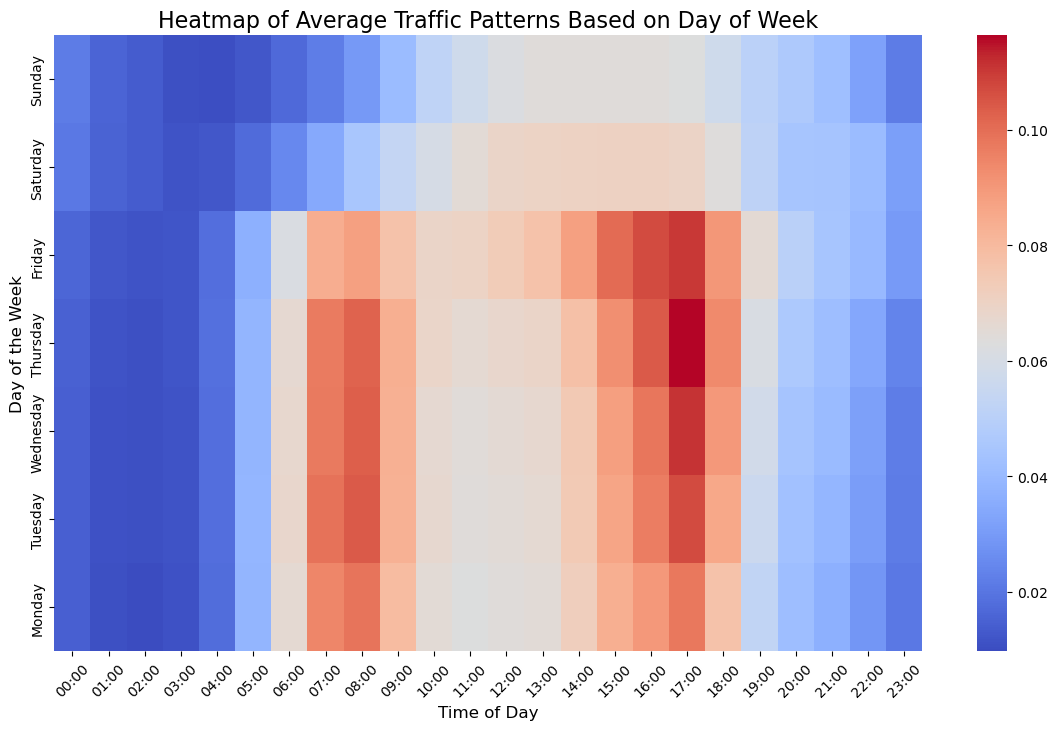

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# aggregate data (average of all sensor per time interval)
def aggregate_data(data):
    """
    Aggregate traffic data by averaging across all sensors.
    Returns a DataFrame with rows as days and columns as time intervals.
    """
    aggregated = np.mean(data, axis=1)
    return aggregated

# aggregate training data 
aggregated_train_data = aggregate_data(train_data)

# reduce time intervals from 10-minute to 1-hour intervals
aggregated_train_data_hourly = aggregated_train_data.reshape(-1, 6).mean(axis=1) # assume 144 intervals, 10-mins/24hrs
aggregated_train_data_hourly = aggregated_train_data_hourly.reshape(-1, 24)  # Reshape back to days x hours

# time intervals with 1-hour increments
time_intervals = [f"{hour:02d}:00" for hour in range(24)]
df = pd.DataFrame(aggregated_train_data_hourly, columns=time_intervals)
df['Day'] = train_labels

# group by day of the week and calculate mean occupancy
day_names = {1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 4: 'Wednesday', 5: 'Thursday', 6: 'Friday', 7: 'Saturday'}
df['Day'] = df['Day'].map(day_names)  # Map numeric labels to day names
grouped = df.groupby('Day').mean()  # Average over all samples for each day

# re-order day of week for Heatmat visual (Sunday to Monday)
day_order = ['Sunday', 'Saturday', 'Friday', 'Thursday', 'Wednesday', 'Tuesday', 'Monday']

# group DataFrame to maintain order sequence
grouped = grouped.reindex(day_order)

# Heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(grouped, cmap='coolwarm', cbar=True, xticklabels=True, yticklabels=True)
plt.title('Heatmap of Average Traffic Patterns Based on Day of Week', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Day of the Week', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.show()


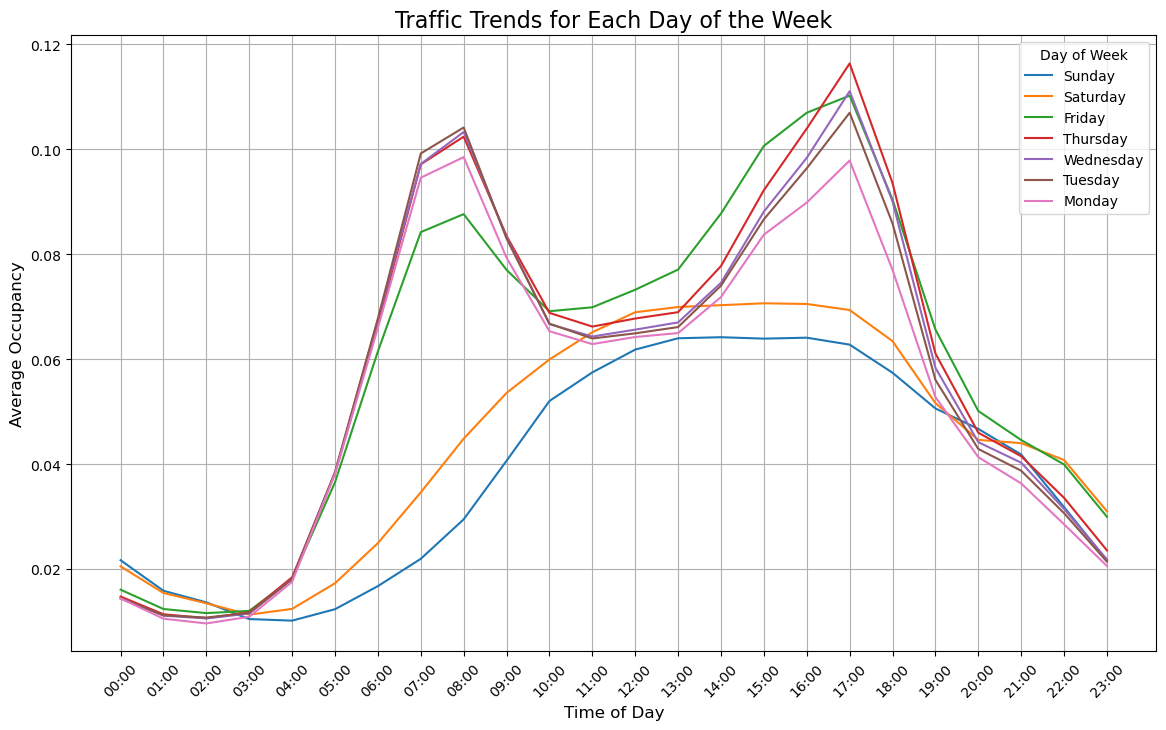

In [27]:
# average traffic trends for each day of week 
plt.figure(figsize=(14, 8))
for day in grouped.index:
    plt.plot(grouped.columns, grouped.loc[day], label=day)

plt.title('Traffic Trends for Each Day of the Week', fontsize=16)
plt.xlabel('Time of Day', fontsize=12)
plt.ylabel('Average Occupancy', fontsize=12)

# update x-axis to 1-hour increments 
plt.xticks(ticks=range(len(grouped.columns)), labels=grouped.columns, rotation=45, fontsize=10)
plt.legend(title='Day of Week', fontsize=10)
plt.grid(True)
plt.show()

In [36]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score

X_train = train_data.reshape(train_data.shape[0], -1) 
X_test = test_data.reshape(test_data.shape[0], -1)

y_train = train_labels
y_test = test_labels

# print shape
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# RandomForestClassifier with hyperparameter tuning (RandomizedSearchCV)
rf = RandomForestClassifier(random_state=44)
param_distributions = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],     }

random_search = RandomizedSearchCV(rf, param_distributions, n_iter=10, cv=3, scoring="accuracy", random_state=44, n_jobs=-1)
random_search.fit(X_train, y_train)

# best parameters
best_params = random_search.best_params_

print("\nBest Parameters (RandomizedSearchCV):", best_params)

# train with best parameters
rf_best = random_search.best_estimator_
rf_best.fit(X_train, y_train)

# predictions
y_pred = rf_best.predict(X_test)

# evaluate & classification report
print("F1 Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

X_train shape: (267, 138672)
X_test shape: (173, 138672)
y_train shape: (267,)
y_test shape: (173,)

Best Parameters (RandomizedSearchCV): {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
F1 Score: 0.9884393063583815

Classification Report:
               precision    recall  f1-score   support

           1       1.00      1.00      1.00        30
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        26
           4       1.00      1.00      1.00        23
           5       0.92      1.00      0.96        22
           6       1.00      0.93      0.96        27
           7       1.00      1.00      1.00        20

    accuracy                           0.99       173
   macro avg       0.99      0.99      0.99       173
weighted avg       0.99      0.99      0.99       173



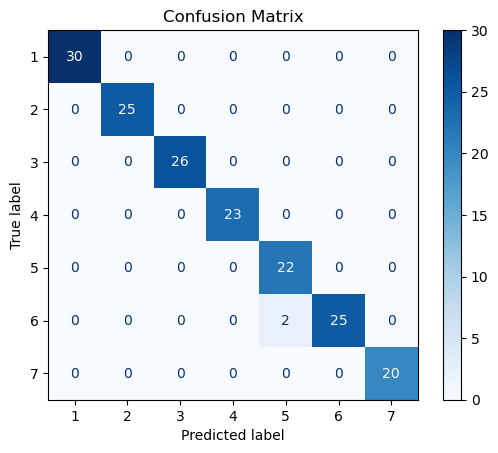

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()